Traffic sign detection and recognition is an active area of research within the scope of intelligent vehicles technologies. A search on google or a scientific articles database, will show many approaches to the problem. It is considered that such function can be used to assist drivers on safely conducting vehicles on a transit that poses a high demand of attention.

This notebook gives some ideas and code useful to solve this problem. A focus is placed on detection and recognition
of speed limit traffic signs, since driving above speed limit is a common infraction drivers that commit. 

It is also restricted to the rules and standards related to the brazilian transit code, though some other countries also use plates that contain many similarities with it.

In Brazil, speed limit road sign uses the R-19 plate or some variation of it. This plate can be distinguished by a red outer circle with a white body containing black digits, that correspond to the desired speed, as shown in the example ![R-19](images/r19.jpg)

Considering an object with these visual caracteristics, it seems reasonable to assume that a segmentation using RED color is a good starting point for detecting the plate and that, once it is detected, we apply tesseract to "read" the speed limit.

Of course, other alternatives exist, such as using a [Convolutional Neural Network (CNN)](https://www.pyimagesearch.com/2019/11/04/traffic-sign-classification-with-keras-and-deep-learning/), or other types of object detector applied to road sign. A problem with CNN, though, is the aquisition of trainning images, its poor explainability and relative slow processing time if not using a GPU or other type of acceleration.

Adopted color segmentation is a commom approach to solve this type of problem due to its simplicity and reasonably low processing time. For simplification, we used tesseract to read the number, but another method could be used.

On the lines below, it is shown the code that creates our detector. Firstly, let's outline the algorithm.

1. White and [color balance](https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc) are performed to compensate for different types of illumination conditions.
2. Blurring is applied to remove some noise, while preserving edges with a bilateral filter.
3. Perform a color quantization or reduction. This process is necessary to enhance and homogenize the colors of the image, since pictures will very likelly come from an uncontrolled environment. Mean Shift was used together with a [simpler mapping version](https://stackoverflow.com/questions/5906693/how-to-reduce-the-number-of-colors-in-an-image-with-opencv/39967704). I included other alternatives, such as, RGB normalization algorithm, which works for RGB color components, the disadvantage is the loss of information. [KMeans](https://medium.com/@elvisdias/color-quantization-with-kmeans-in-opencv-99dbd0bde91b) may be an alternative, but may be slow.
4. Once reduction is performed, RED color mask is extracted using HSV color space, in order to obtain a binary image.
5 In the binary image, an erosion (in the present case an open) operation is performed to reduce number of contours and then the connected components of the image are found. This step of getting the connected components is important to transform the image to desired feature space. This is not crucial, though, because the circular Hough transform used in next step can also create our feature space, but usage of connected components simplifies the problem.
6. It is assumed that in the feature space, speed limit road signs, contain three properties: Area of conected component bounding box is greater than a certain value (fixed to 1000 - depends on type of image), the ratio (area of connected)/(bounding box area) is less than a fixed value (fixed to 0.4) and last property: it is a circle. With these three morphological properties ou detector can be created using a "rule based approach". Later, on this article, I will rewrite this rule to use a decision tree classified.
7. Once the road sign is detected, apply tesseract to detect text.

In [2]:
%matplotlib inline

In [1]:
import cv2
import numpy as np
import pytesseract
import time
import glob
import matplotlib.pyplot as plt
import enum

class RegularizationType(enum.Enum):
   MeanShift = 1
   Mapping = 2
   Kmeans = 3
   Normalized = 4
   
   
'''
RGB normalization or quantization
'''  
def normalized(rgb):
    
        h,w,c=rgb.shape
        norm=np.zeros((h,w,c),np.float32)
        norm_rgb=np.zeros((h,w,c),np.uint8)

        
        b=rgb[:,:,0]
        g=rgb[:,:,1]
        r=rgb[:,:,2]

        sum=b+g+r
        
        # let cv.divide handle zero division        
        norm[:,:,0]=(cv2.divide(b,sum,scale=255))
        norm[:,:,1]=(cv2.divide(g,sum,scale=255))
        norm[:,:,2]=(cv2.divide(r,sum,scale=255))

        # convert from float to 8 bit
        norm_rgb=cv2.convertScaleAbs(norm)
        return norm_rgb   

'''
Quantization or color reduction using K-means
'''
def quantize(image,NCLUSTERS=8,NROUNDS=2,type=RegularizationType.MeanShift):
    
    if type == RegularizationType.MeanShift:
        return cv2.pyrMeanShiftFiltering(image, 10, 50)
    elif type == RegularizationType.Mapping:
        div = 64
        image2 = image // div * div + div // 2
        return image2
    elif type == RegularizationType.Normalized:
        return normalized(image)
    else:          
        height, width, channels = image.shape
        samples = np.zeros([height*width, 3], dtype = np.float32)
        count = 0
        
        for x in range(height):
            for y in range(width):
                samples[count] = image[x][y] #BGR color
                count += 1
                
        compactness, labels, centers = cv2.kmeans(samples,
                                            NCLUSTERS, 
                                            None,
                                            (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10000, 0.0001), 
                                            NROUNDS, 
                                            cv2.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        res = centers[labels.flatten()]
        image2 = res.reshape((image.shape))
        
        return image2

'''
Reads an image and add to list
'''
def read_img(img_list, img):
    n = cv2.imread(img, cv2.IMREAD_COLOR)
    img_list.append(n)
    return img_list


'''
Extract digits from the string
'''
def getDigits(str):
    r=''
    for s in str:
        if s.isdigit():
            r+=s
    return r

'''
Simple and useful color balancing algorithms
'''
def simplest_cb(img, percent=1):
    out_channels = []
    channels = cv2.split(img)
    totalstop = channels[0].shape[0] * channels[0].shape[1] * percent / 200.0
    for channel in channels:
        bc = cv2.calcHist([channel], [0], None, [256], (0,256), accumulate=False)
        lv = np.searchsorted(np.cumsum(bc), totalstop)
        hv = 255-np.searchsorted(np.cumsum(bc[::-1]), totalstop)
        lut = np.array([0 if i < lv else (255 if i > hv else round(float(i-lv)/float(hv-lv)*255)) for i in np.arange(0, 256)], dtype="uint8")
        out_channels.append(cv2.LUT(channel, lut))
    return cv2.merge(out_channels)

    
def area(x1,y1,x2,y2):
    a = abs(x2-x1)*abs(y2-y1)
    return a


'''
Show connected components
'''    
def imshow_components(labels):
    # Map component labels to hue val
    label_hue = np.uint8(179*labels/np.max(labels))
    blank_ch = 255*np.ones_like(label_hue)
    labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

    # cvt to BGR for display
    labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

    # set bg label to black
    labeled_img[label_hue==0] = 0

    cv2.imshow('labeled', labeled_img)
    cv2.waitKey()
    cv2.destroyWindow('labeled')
    
'''
Speed road sign detector and recognizer. Implements road sign detector algorithm
'''
def get_speed(img):
    config = ('-l eng --oem 2 --psm 11 ')
    
    # tesseract will read from this binary image to avoid noise
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    _,grayb=cv2.threshold(gray,80,255,cv2.THRESH_BINARY)       
    
    imgn = quantize(quantize(img),RegularizationType.Mapping)
   
    speeds =[]   

    # Range for lower red

    lower_red = np.array([0,0,90])
    upper_red = np.array([90,90,160])
    mask1 = cv2.inRange(imgn, lower_red, upper_red)
    
    # Range for upper red
    lower_red = np.array([0,0,140])
    upper_red = np.array([120,120,255])    

    mask2 = cv2.inRange(imgn,lower_red,upper_red)    
  
    
    # Generating the final mask to detect red color
    mask3 = mask1+mask2
    

    # work in red contour space given by red connected components
    num_labels, labels_im = cv2.connectedComponents(cv2.morphologyEx(mask3, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8)) ) 
    
    # show connected components
    #imshow_components(labels_im)
    
    for i in range(1,num_labels):
        idx = np.where(labels_im==i)
        y1=min(idx[0])
        x1=min(idx[1])
        y2=max(idx[0])
        x2=max(idx[1])
        labelmask = np.uint8(((labels_im==i)*255))
        roimask = labelmask[y1:y2,x1:x2]

        
        if area(x1,y1,x2,y2) > 1000 and np.sum(roimask>0)/area(x1,y1,x2,y2)<0.4:
                   
            # use HOUGH_GRADIENT_ALT which is more accurate
            circles = cv2.HoughCircles(roimask,cv2.HOUGH_GRADIENT_ALT,2,10,
                                 param1=300,param2=0.8)
            
            if circles is not None:
                circles = np.uint16(np.around(circles))
                
                for i in circles[0,:]:
                    cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)

                    (H,W,_) = imgn.shape
                    margin=5
                    
                    y1l = y1-margin if y1-margin >= 0 else y1
                    y2l = y2+margin if y2-margin <= H else y2
                    x1l = x1-margin if x1-margin >= 0 else x1
                    x2l = x2+margin if x2+margin <= W else x2
                    grayb=grayb+labelmask
                    roi = grayb[:,:][y1l:y2l,x1l:x2l]

                    text = pytesseract.image_to_string(roi, config=config)
                    speeds.append(getDigits(text))

    return img,speeds


Having defined helper methods, it is time to evaluate the detector against a set of images. A grid of images containing detected signs is shown, the title contains recognized speed limits.

time 15.152626276016235


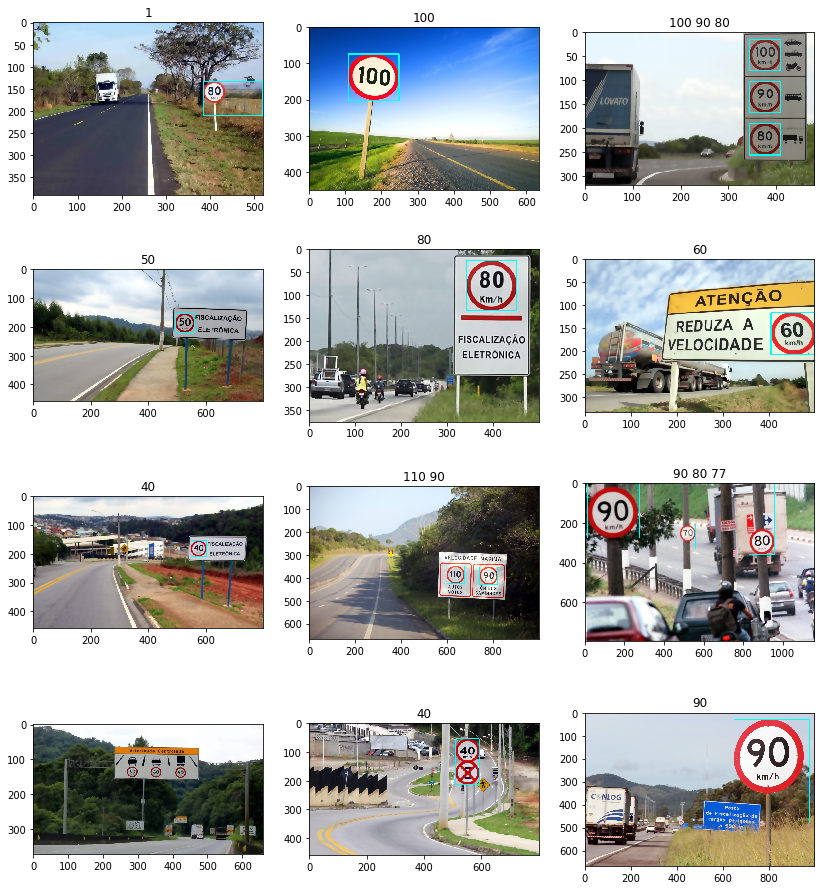

In [2]:

list_ = []
rows=4
cols=3

ax=[]

i=0

path = glob.glob("images/placa*.jpg")

fig = plt.figure(figsize=(14, 16))

cv_image = [read_img(list_, imgp) for imgp in path]

global_start_time = time.time()

wb = cv2.xphoto.createGrayworldWB()

for img in list_:    
            
    imb=wb.balanceWhite(img)
    
    imbb = simplest_cb(imb)
    
    blur = cv2.bilateralFilter(imbb,9,75,75)    
    
    imgd,speedl = get_speed(blur)
    
    ax.append( fig.add_subplot(rows, cols, i+1) )
    
    ax[-1].set_title(' '.join(map(str, speedl))) 
    
    plt.imshow(cv2.cvtColor(imgd,cv2.COLOR_BGR2RGB))
                     
    i+=1

print('time (s) ',time.time() - global_start_time)    
plt.show()

It can be seen that in only 1 out of 12 images, no traffic sign was detected and from detected signs, 2 were incorrectly recognized.

It is also possible to check that execution time is a bit slow, due to the fact that pytesseract is slow. One alternative to improve this is to parallelize the code execution as shown with classifier example below. Another alternatives would include direct use of (tesseract API)[https://github.com/sirfz/tesserocr] or try another approach.

Now, lets rewrite detector code to use a categorical classifier, instead of a set of rules. In fact, the rules will be used to build the feature vector, since the formation of its elements is known.

In [8]:
from sklearn import tree

SAMPLES=150


np.random.seed(3)

#randomly generates area
areas = np.random.rand(SAMPLES)*5000

np.random.seed(5)

#randomly generates fractions
fracs = np.random.rand(SAMPLES)


#randomly generates circles according with rules
circs = np.array(list(map(lambda tup: np.random.randint(5) if tup[0] > 1000 and tup[1] < 0.4 else 0, zip(areas,fracs))))


target = np.array(list(map(lambda tup: 1 if (tup[0] > 1000 and tup[1]) < 0.4 and tup[2] > 0 else 0, zip(areas,fracs,circs))))

model = tree.DecisionTreeClassifier()

#creates a trainning vector
X = np.stack((areas,fracs,circs),axis=1)


model = model.fit(X,target)


'''
Speed road sign detector and recognizer. Implements road sign detector algorithm
using a model
'''
def get_speedCategorical(img,model):
    config = ('-l eng --oem 2 --psm 11 ')
    
    wb = cv2.xphoto.createGrayworldWB()
    
    imb=wb.balanceWhite(img)
    
    imbb = simplest_cb(imb)
    
    blur = cv2.bilateralFilter(imbb,9,75,75)      
    
    # tesseract will read from this binary image to avoid noise
    gray=cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
    _,grayb=cv2.threshold(gray,80,255,cv2.THRESH_BINARY)       
    
    imgn = quantize(quantize(blur),RegularizationType.Mapping)
   
    speeds =[]   
    
    # Range for lower red
    lower_red = np.array([0,0,90])
    upper_red = np.array([90,90,160])
    
    mask1 = cv2.inRange(imgn, lower_red, upper_red)
    
    # Range for upper red
    lower_red = np.array([0,0,140])
    upper_red = np.array([120,120,255])
    

    mask2 = cv2.inRange(imgn,lower_red,upper_red)    
    
    # Generating the final mask to detect red color
    mask3 = mask1+mask2
       

    # work in red contour space given by red connected components
    num_labels, labels_im = cv2.connectedComponents(cv2.morphologyEx(mask3, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8)) ) 
    
    # show connected components
    #imshow_components(labels_im)
    
    for i in range(1,num_labels):
        idx = np.where(labels_im==i)
        y1=min(idx[0])
        x1=min(idx[1])
        y2=max(idx[0])
        x2=max(idx[1])
        labelmask = np.uint8(((labels_im==i)*255))
        roimask = labelmask[y1:y2,x1:x2]

        # use HOUGH_GRADIENT_ALT which is more accurate
        
        circles = cv2.HoughCircles(roimask,cv2.HOUGH_GRADIENT_ALT,2,10,param1=300,param2=0.8)
        
        A = area(x1,y1,x2,y2)
        F = np.sum(roimask>0)/area(x1,y1,x2,y2)
        
        if circles is not None:
            circles = np.uint16(np.around(circles)) 
            C = len(circles)
        else:
            C = 0
        
        if  model.predict(np.array([A,F,C]).reshape(1,-1))[0]:
                
            for i in circles[0,:]:
                cv2.rectangle(blur,(x1,y1),(x2,y2),(0,255,255),2)

                (H,W,_) = imgn.shape
                margin=5

                y1l = y1-margin if y1-margin >= 0 else y1
                y2l = y2+margin if y2-margin <= H else y2
                x1l = x1-margin if x1-margin >= 0 else x1
                x2l = x2+margin if x2+margin <= W else x2
                grayb=grayb+labelmask
                roi = grayb[:,:][y1l:y2l,x1l:x2l]

                text = pytesseract.image_to_string(roi, config=config)
                speeds.append(getDigits(text))

    return blur,speeds

Run evaluation code again

time 5.953376770019531


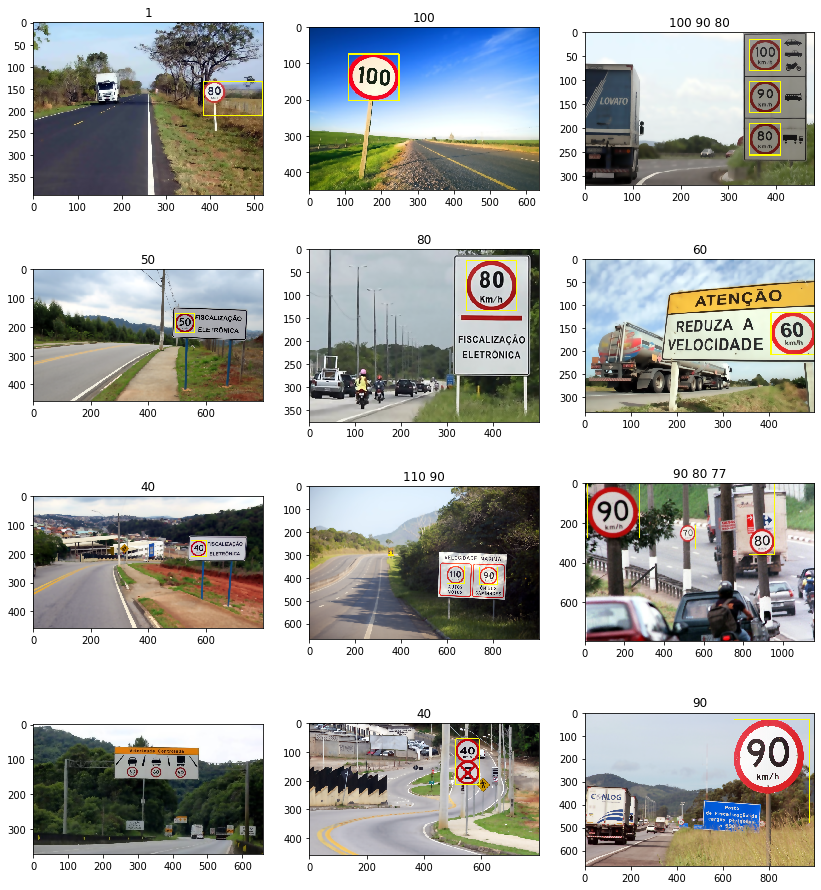

In [9]:

list_ = []
rows=4
cols=3

ax=[]

i=0

path = glob.glob("images/placa*.jpg")

fig = plt.figure(figsize=(14, 16))

cv_image = [read_img(list_, imgp) for imgp in path]

global_start_time = time.time()

result=[]

import concurrent.futures
with concurrent.futures.ProcessPoolExecutor(max_workers=8) as executor:
    for imgl in list_:    
        result.append( executor.submit(get_speedCategorical,imgl,model))

for r in result:
        
    ax.append( fig.add_subplot(rows, cols, i+1) )      
      
    ax[-1].set_title(' '.join(map(str, r.result()[1] ))) 
    
    plt.imshow(cv2.cvtColor(r.result()[0],cv2.COLOR_BGR2RGB))  
    i+=1  

print('time',time.time() - global_start_time)    
plt.show()

That is it, replacing our rule based detector by a classification model also works, as well as, execution time was reduced with the parallel approach